# Churn Prediction of Interconnect clients. 

Summary: In this project, interconnect client datasets were merged and cleaned. After some data visualization, it was clear that a mix of features had varrying impacts on customer churn. The following Classifiers were trained to predict churn: LogisticRegression, RandomForestClassifier, CatBoostClassifier, K-nearest Neighbors, and VotingClassifier. The trained CatBoostClassifier and the VotingClassifier returned the highest AUC-ROC score of about 0.9 and 0.89 on the test set, while also having a high accuracy above 0.8. 

Prompt: The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

## Libraries 

In [1]:
import pandas as pd
import numpy as np

# ploting data
import matplotlib.pyplot as plt
import seaborn as sns

# data processing for model training
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold


# Models
from sklearn.dummy import DummyClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

# model scoring
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score

## Load Data 

In [2]:
# load data
df_contract = pd.read_csv("/datasets/final_provider/contract.csv")
df_personal = pd.read_csv("/datasets/final_provider/personal.csv")
df_internet = pd.read_csv("/datasets/final_provider/internet.csv")
df_phone = pd.read_csv("/datasets/final_provider/phone.csv")

In [3]:
# sample the datasets
display(df_contract.sample(), df_personal.sample(), df_internet.sample(), df_phone.sample())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


,customerID,gender,SeniorCitizen,Partner,Dependents
399,5876-QMYLD,Female,0,Yes,Yes


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3823,2533-TIBIX,DSL,Yes,No,No,No,No,No


,customerID,MultipleLines
6092,9488-FYQAU,Yes


First Look Notes:
- common key for all : "customerID"
- merge datasets to one dataframe for easier access and training. ** outer merge
- column names need to be in snake_case

## Clean Data and Feature Engineering

### Merge datasets

In [4]:
# merge datasets
all_data = pd.merge(df_contract, df_personal, on='customerID', how='outer')
all_data = pd.merge(all_data, df_internet, on='customerID', how='outer')
all_data = pd.merge(all_data, df_phone, on='customerID', how='outer')

# saving a copy of the data 
original_data = all_data.copy()

In [5]:
# rename columns to snake_case 
all_data.rename(columns={
        'customerID':'customer_id', 'BeginDate':'begin_date', 'EndDate':'end_date', 'Type':'type', \
        'PaperlessBilling':'paperless_billing', 'PaymentMethod':'payment_method', 'MonthlyCharges':'monthly_charges',\
        'TotalCharges':'total_charges', 'gender':'gender','SeniorCitizen':'senior_citizen', 'Partner':'partner',\
        'Dependents':'dependents', 'InternetService':'internet_service', 'OnlineSecurity':'online_security', \
        'OnlineBackup':'online_backup', 'DeviceProtection':'device_protection', 'TechSupport':'tech_support',\
       'StreamingTV':'streaming_tv', 'StreamingMovies':'streaming_movies', 'MultipleLines':'multiple_lines'\
    },
    inplace=True)

In [6]:
# check for duplicates in customer id column
all_data['customer_id'].duplicated().sum()

0

In [7]:
# all unique customers, the costomer id can be removed
all_data.drop('customer_id', axis=1, inplace=True)

In [8]:
##########################
# function to get unique values for each column 
def columns_values(df):
    for column in df.columns.tolist():
        print(f'{column}: {df[column].unique()}\n')

In [9]:
columns_values(all_data)

begin_date: ['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '2016-06-01' '2015-08-01' '2015-11-01' '2014-06-01' '2017-01-01'
 '2015-07-01' '2020-02-01' '2016-11-01' '2013-11-01' '2014-01-01

In [10]:
# how many null values per column?
for column in all_data.columns.tolist():
    print(f'{column} : {round(all_data[column].isna().sum()/len(all_data[column]), 2)}')

begin_date : 0.0
end_date : 0.0
type : 0.0
paperless_billing : 0.0
payment_method : 0.0
monthly_charges : 0.0
total_charges : 0.0
gender : 0.0
senior_citizen : 0.0
partner : 0.0
dependents : 0.0
internet_service : 0.22
online_security : 0.22
online_backup : 0.22
device_protection : 0.22
tech_support : 0.22
streaming_tv : 0.22
streaming_movies : 0.22
multiple_lines : 0.1


Notes:
    
    - end_date only has a few values. 
        - 'No': no churn 
        - interestingly churn dates in this dataset is round october to december and January
            - the years that a client has been with the company could be useful
            - this column could be changed to have 0 and 1 to act as a target for forecasting churn.
            
    - start dates are all on the first date of the month. 
        
    - total_charges should be a float
    - charges should be standardized
    
    - Many columns have 'Yes' and 'No' values. change to 0 and 1 for Machine learning 
    
    - Services columns have null values?  22% for most services and 10% for mutiple lines. Could be that the data was not recorded or skipped because the client didn't take these services. 
        - Missing data could be replaced with 'No' 
        - Or possibly filled with majority or by patterns in the other columns like monthly_charge
            

### Replace null values in services as 'No'

In [11]:
# assuming Null = No
all_data.fillna('No', inplace=True)
all_data.isna().sum().sum()

0

### New column 'tenure': number of months with the company/plan

In [12]:
# begin_date and to datetime type
all_data['begin_date'] = pd.to_datetime(all_data['begin_date'])
all_data['begin_date'].dtypes

dtype('<M8[ns]')

In [13]:
# since the end_date column have string values, copying the dates to new column 'tenure'
all_data['tenure'] = pd.to_datetime(all_data[all_data['end_date'] !='No']['end_date'])
all_data['tenure'].isna().sum()

5174

In [14]:
# the null values mean the customer is still with the company. 
# filling in the null with the max/recent begin_date 
all_data['tenure'].fillna(all_data['begin_date'].max(), inplace=True)

In [15]:
# function to get the number of months from begin_date and end_date columns

def get_months(recent_date, previous_date):
    
    months = 0
    years = 0
    
    # same year 
    if (recent_date.year == previous_date.year):
        return (recent_date.month - previous_date.month);
    
    # one year after
    # not counting the month of february 2020 since no total charges were recorded. 
    months = (13- previous_date.month) + (recent_date.month-1)
    
    # more than 1 year in between start and 'end'/continuation
    years = recent_date.year - previous_date.year;
    if (years > 1):
        months += ((years-1)*12)
    
    return months;

In [16]:
# tenure column
all_data['tenure'] = all_data.apply(lambda row: get_months(row['tenure'], row['begin_date']), axis=1)


### create year_start column from begin_date

In [17]:
all_data['year_start'] = all_data['begin_date'].dt.year

### Clean Target column: end_date (rename: 'churn')

In [18]:
all_data['end_date'] = all_data['end_date'].apply(lambda x:0 if x=='No' else 1)
# rename 'end_date' as 'churn'
all_data.rename(columns={'end_date': 'churn'}, inplace=True)


### total_charges column to float type

In [19]:
# total_charges to numeric
all_data['total_charges'] = pd.to_numeric(all_data['total_charges'], errors='coerce')
all_data['total_charges'].isna().sum()

11

In [20]:
# checking columns where total charges is null 
all_data[all_data['total_charges'].isna()]

,begin_date,churn,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,tenure,year_start
488,2020-02-01,0,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,...,DSL,Yes,No,Yes,Yes,Yes,No,No,0,2020
753,2020-02-01,0,Two year,No,Mailed check,20.25,NaN,Male,0,No,...,No,No,No,No,No,No,No,No,0,2020
936,2020-02-01,0,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,...,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,2020
1082,2020-02-01,0,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,...,No,No,No,No,No,No,No,Yes,0,2020
1340,2020-02-01,0,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,...,DSL,Yes,Yes,Yes,Yes,Yes,No,No,0,2020
3331,2020-02-01,0,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,...,No,No,No,No,No,No,No,No,0,2020
3826,2020-02-01,0,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,...,No,No,No,No,No,No,No,Yes,0,2020
4380,2020-02-01,0,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,...,No,No,No,No,No,No,No,No,0,2020
5218,2020-02-01,0,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,...,No,No,No,No,No,No,No,No,0,2020
6670,2020-02-01,0,Two year,No,Mailed check,73.35,NaN,Female,0,Yes,...,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0,2020


In [21]:
# total_charges may be empty because the client just started their plan 
all_data['begin_date'].max()

Timestamp('2020-02-01 00:00:00')

The start_date for all the rows is 2020-02-01 is the max start_date, so they likely just started with their plan hence null total_charges. So null could be replace with 0; no total charge yet. 

In [22]:
# replace null total_charges with 0
all_data['total_charges'].fillna(0, inplace=True)
all_data['total_charges'].isna().sum()

0

### Dropping 'begin_date' columns 

In [23]:
# since we have the tenure column begin data can be dropped 
all_data.drop('begin_date', axis=1, inplace=True)

In [24]:
# review columns 
columns_values(all_data)

churn: [0 1]

type: ['Month-to-month' 'One year' 'Two year']

paperless_billing: ['Yes' 'No']

payment_method: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

monthly_charges: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]

total_charges: [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]

gender: ['Female' 'Male']

senior_citizen: [0 1]

partner: ['Yes' 'No']

dependents: ['No' 'Yes']

internet_service: ['DSL' 'Fiber optic' 'No']

online_security: ['No' 'Yes']

online_backup: ['Yes' 'No']

device_protection: ['No' 'Yes']

tech_support: ['No' 'Yes']

streaming_tv: ['No' 'Yes']

streaming_movies: ['No' 'Yes']

multiple_lines: ['No' 'Yes']

tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]

year_start: [2020 2017 2019 2016 2018 2014 2015 2013]



## Data Visualization 

In [25]:
# check target class inbalance
all_data['churn'].value_counts()

0    5174
1    1869
Name: churn, dtype: int64

### How does 'churn' relate to the number of months client is with plan?

In [26]:
# range of months in tenure column
print(f"range for tenure: 0 to {all_data['tenure'].max()} months")

range for tenure: 0 to 72 months


<AxesSubplot:title={'center':'Quantity of churn and no churn by Tunure Month'}, xlabel='tenure', ylabel='frequency'>

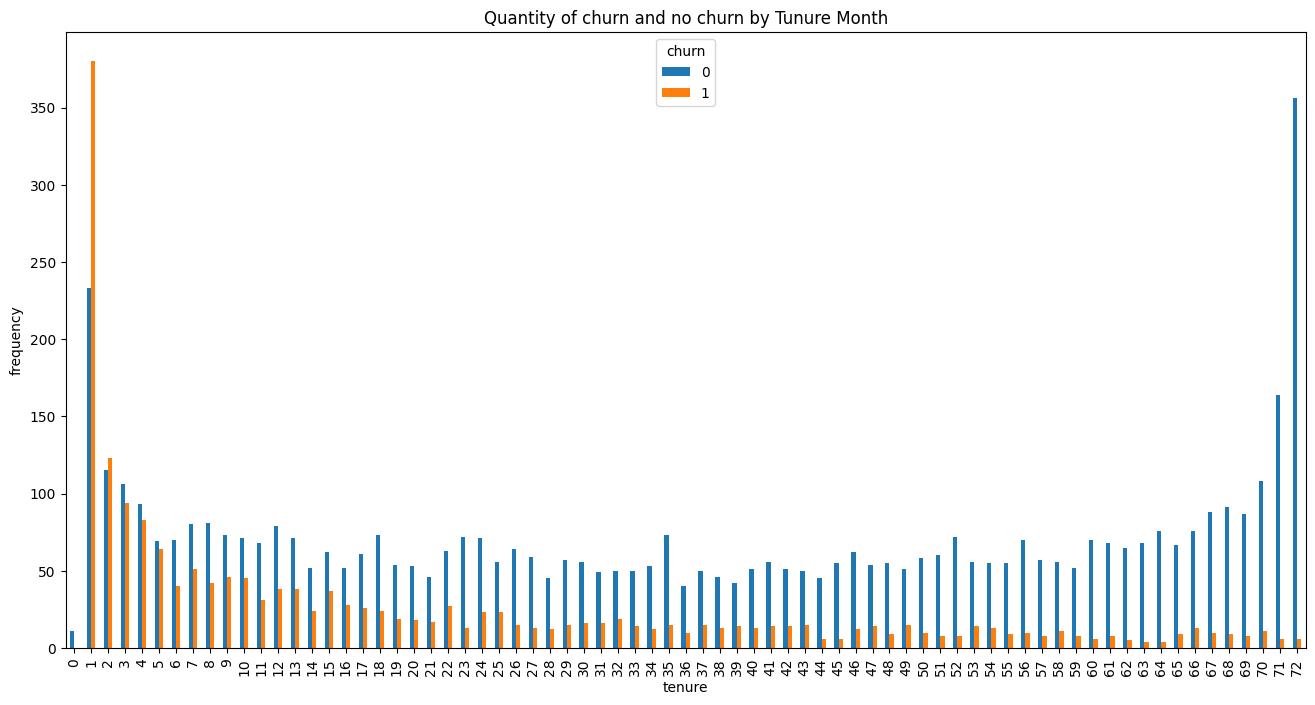

In [27]:
# churn column vs tenure 
ct = pd.crosstab(all_data['tenure'], all_data['churn'])
ct.plot(kind='bar', stacked=False, figsize=(16, 8), title='Quantity of churn and no churn by Tunure Month', ylabel='frequency')


* The ratio of client churn to no churn is higher at the fist month and gradually decreased after the second month. 
* There is a lower churn percentage for months> 70
* could the high quantity of churns during a clients first year mean there are more monthy plan client churns. 

<AxesSubplot:title={'center':'plan vs. churn (first 12 months)'}, ylabel='type'>

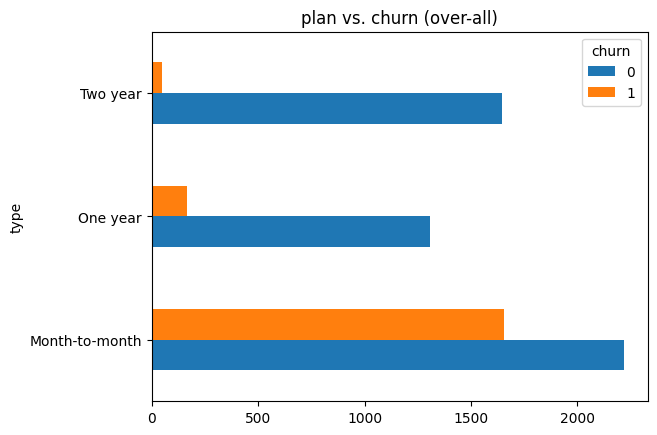

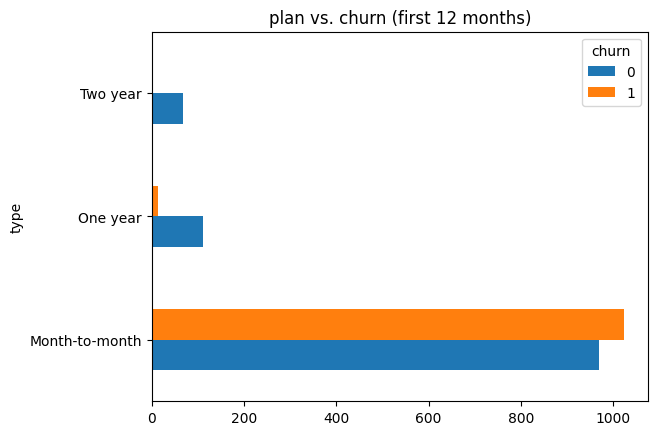

In [28]:
# churn quantity by plan type
all_data.groupby('type')['churn'].value_counts().unstack().plot(kind='barh', title='plan vs. churn (over-all)', ylabel='clients')
# churn quantity by plan type during first 12 months
all_data[all_data['tenure'] <= 12].groupby('type')['churn'].value_counts().unstack().plot(kind='barh', title='plan vs. churn (first 12 months)', ylabel='clients')


Looks like those with a monthlyplan are more prone to cancel their plan/service, especially during the first year. why is that? since we don't have much feedback on how the customers felt about the services we could focus on the charges. 

### Distribution of charges for churn and no churn clients

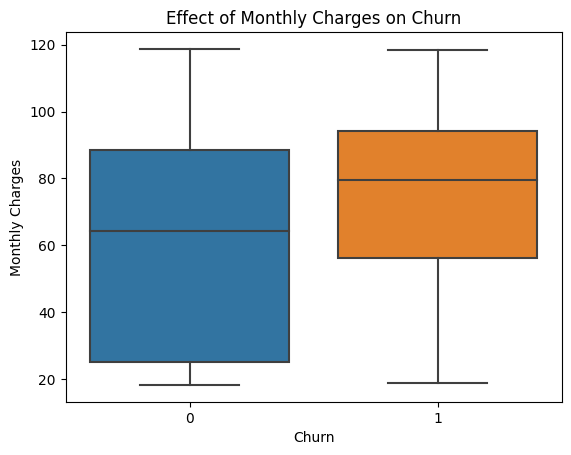

In [29]:
sns.boxplot(data=all_data, x='churn', y='monthly_charges')
plt.title('Effect of Monthly Charges on Churn')
plt.xlabel('Churn')
plt.ylabel('Monthly Charges')
plt.show()


churn customers indeed have a higher mean and distribution of charges.  

### Distribution of charges 

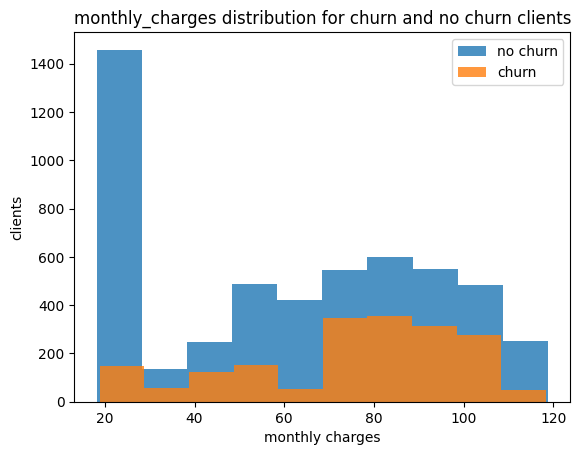

In [30]:
# histogram of charges. what is the distribution of charges for those who churned and those who didn't
plt.hist(all_data[all_data['churn']==0]['monthly_charges'], label='no churn', alpha=0.8)
plt.hist(all_data[all_data['churn']==1]['monthly_charges'], label='churn', alpha=0.8)
plt.title('monthly_charges distribution for churn and no churn clients')
plt.xlabel('monthly charges')
plt.ylabel('clients')
plt.legend()
plt.show()

There is a a higher quantity of clients with a monthly charges between 70 and 110 who canceled their plan compared to charges lower than 70. It is clear that the cost of the plan does have a significant impact on the behavior of clients. 

In [31]:
all_data.columns.tolist()

['churn',
 'type',
 'paperless_billing',
 'payment_method',
 'monthly_charges',
 'total_charges',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines',
 'tenure',
 'year_start']

In [32]:
plot_columns = all_data.columns.tolist()
#plot_columns.remove(['monthly_charges', 'total_charges'])
#plot_columns

In [33]:
plot_columns = [
 'type',
 'paperless_billing',
 'payment_method',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines',
 'year_start']

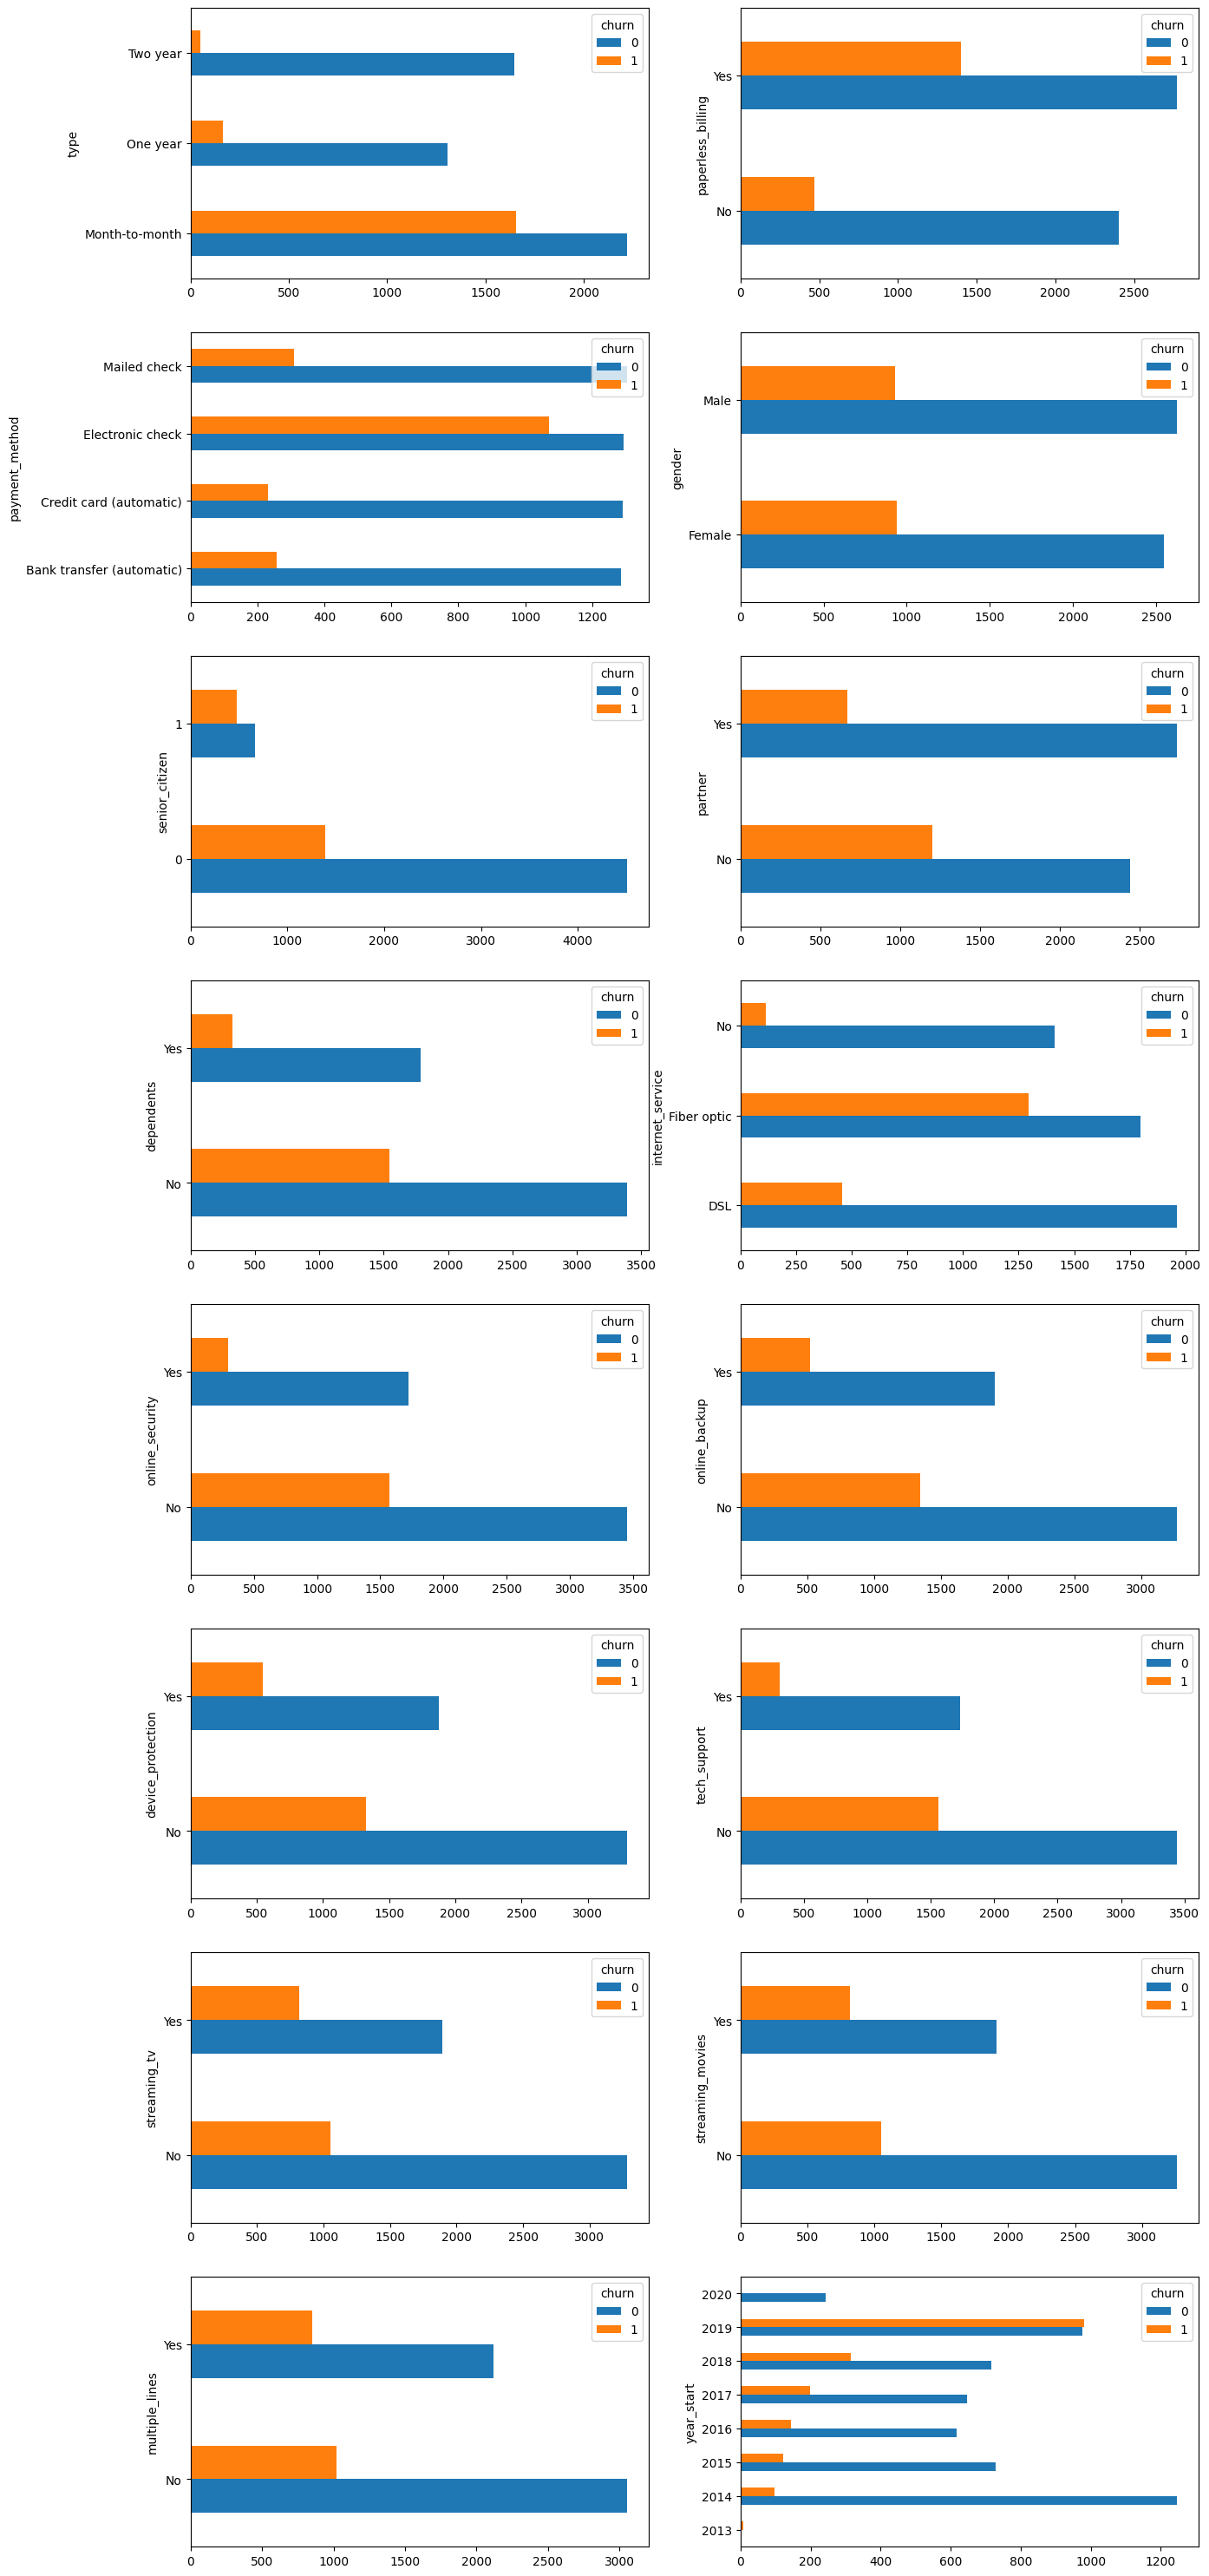

In [34]:
fig, axs = plt.subplots(8, 2, figsize=(15,38),sharex=False)
x, y = 0, 0

for col in plot_columns:
    if (y==2):
        y=0
        x+=1
        
    #plt.bar(data=all_data, x=churn, y='col', orient='v', hue=col, ax=axs[x,y])
    all_data.groupby(col)['churn'].value_counts().unstack().plot(kind='barh', ax=axs[x,y])
    axs[x,y].legend(loc='upper right', title='churn')
    axs[x,y].set_xlabel('')
    y+=1

plt.show()

Notes by plots: 
- type: high ratio of churn clients with a monthly plan. this is to be expected since there was a high quantity of churn clients in the first year. 
- paperless_billing: Those with paperless billing have a higher churn. why is that?
- payment_method: highest churn for the electronic check clients compared to the rest of the methods. 
- gender: no significant difference in churn for gender
- partner: higher churn clients without a partner. 
- internet_service: fiber_optic clients churn is much higher. 
- streaming services and multiple_lines: quantity of churn clients is consistent if they had the service or not. 
- year_start: there is gradual rise in client churn from 2014 to 2018, the no churn clients did not grow much during these years. The quantity of churn and no churn is even for 2019. This could be further studied with more data from that year. there is little or no churn for 2020, which is expected sicne that data only includes up to 2-1-2020
- other features values don't appear to have a distinguishable impact on the churn 

Considering the varrying degrees of impact of each feature on the churn of interconnect's cliets, machine learning models would be able to learn from the feature values and predict the likely hold of a client canceling their plan. 

Plan of Action 

1. The categorical columns need to be label encoded for machine learning
2. Normalize Charges using StandardScaler 
3. Machine Learning:
    * a logistic regresssion, and random forest classifier could be a good start
    * a Gradient Boosting model like lightGBM might give better predictive accuracy for reaching AUC-ROC >= 0.88
    * I am also curious about how a KNN model might do with this data set. 

## Final Data Preperation before model training 

### new column base_charges

The monthly charges may have changed over time for clients. The base_charges (product of monthyly charge and tenure months) could be helpful to the model to distingush the longterm clients. 

In [35]:
all_data['base_charges'] = all_data['monthly_charges'] * all_data['tenure']

### Label encoding on categorical columns

In [36]:
# categorical columns 
object_type_columns = all_data.select_dtypes(include='object').columns.tolist()
object_type_columns

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

In [37]:
# label encoding categorical columns
label_encoder = LabelEncoder()

for column in object_type_columns:
    all_data[column] = label_encoder.fit_transform(all_data[column])

### Data Spliting and scaling charges columns

In [38]:
# data spliting features and target 
features = all_data.drop('churn', axis=1)
target= all_data['churn']

In [39]:
# train and test data split
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=42)

In [40]:
# scaling columns with charges. 
scaler = StandardScaler()
features_train_scaled = features_train.copy()
charges_columns = ['monthly_charges', 'total_charges', 'base_charges']
features_train_scaled[charges_columns] = scaler.fit_transform(features_train_scaled[charges_columns])

features_test_scaled = features_test.copy()
features_test_scaled[charges_columns] = scaler.transform(features_test_scaled[charges_columns])


In [41]:
# sample view
features_test_scaled.sample()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,tenure,year_start,base_charges
321,2,1,2,-0.159105,0.872558,0,0,1,1,0,0,1,1,1,1,1,0,72,2014,0.899128


### Upsampling data

In [42]:
# function to upsample data
def upsample(features, target, repeat):
    # Separate the minority and majority classes
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    # Upsample the minority class (1)
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    # Shuffle the upsampled dataset
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

In [43]:
# view imbalance again 
target_train.value_counts()

0    3635
1    1295
Name: churn, dtype: int64

In [44]:
# upsampling train datasets. repeat = 2 
features_upsampled, target_upsampled = upsample(
    features_train_scaled, target_train, 2
)

In [45]:
# upsampled data imbalance
target_upsampled.value_counts()

0    3635
1    2590
Name: churn, dtype: int64

In [46]:
# overview of column values
columns_values(features_upsampled)

type: [0 2 1]

paperless_billing: [1 0]

payment_method: [2 3 1 0]

monthly_charges: [ 0.71354247 -1.35857933 -1.47139301 ...  1.63098311  1.58453042
 -0.8857573 ]

total_charges: [-0.48831874 -0.73343149 -0.54936519 ... -0.58125678  0.59965874
  1.70436551]

gender: [0 1]

senior_citizen: [0 1]

partner: [0 1]

dependents: [0 1]

internet_service: [1 2 0]

online_security: [0 1]

online_backup: [1 0]

device_protection: [0 1]

tech_support: [0 1]

streaming_tv: [0 1]

streaming_movies: [1 0]

multiple_lines: [0 1]

tenure: [14 23 51  3 68  1 37 72  6 13 71 66  7  2 27 12 32 26 15 24  5 29 60 20
 54 17 43 31 19 22 11 39 47 42 52  4 40 16 49 33 44 62 56 57 10 53 45 65
 61 25 48 63  9 38  8 41 70 59 34 35 50 21 58 69 28 55 64 36 67 30 18 46
  0]

year_start: [2018 2015 2019 2014 2016 2017 2020 2013]

base_charges: [-0.47659962 -0.76823109 -0.54965669 ...  0.29868959  0.60610404
  1.63929247]



## Model training using scaled data

<b> Function to get model scores and roc curve <b>

In [47]:
# Initialize an empty list to store the scores
scorers = []

def get_scores(model, features_valid, target_valid, index_name):
    prediction_probabilities = model.predict_proba(features_valid)[:, 1]
    predictions = model.predict(features_valid)
    
    roc_auc = roc_auc_score(target_valid, prediction_probabilities)
    accuracy = accuracy_score(target_valid, predictions)
    f1 = f1_score(target_valid, predictions)
    scores = pd.DataFrame([{ 'ROC_AUC': roc_auc, 'Accuracy': accuracy, 'F1 Score': f1 }], index=[index_name])
    scorers.append(scores)
    
    fpr, tpr, _ = roc_curve(target_valid, prediction_probabilities)

    plt.figure(figsize=(7, 4))
    plt.plot(fpr, tpr, label=f'{index_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{index_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)  # Add grid to the plot
    plt.show()  
    
    return scores


In [48]:
random_state = 42

### DummyClassifier

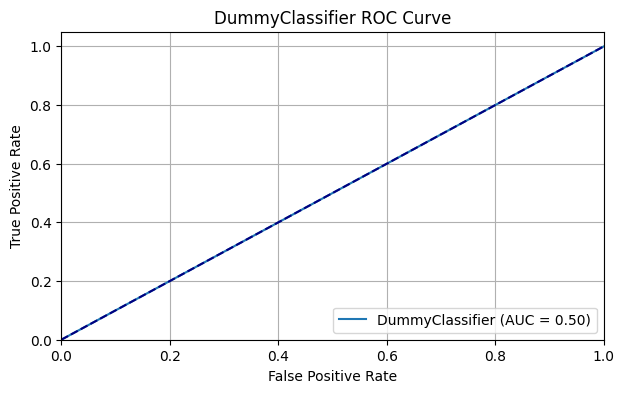

,ROC_AUC,Accuracy,F1 Score
DummyClassifier,0.5,0.728348,0.0


In [49]:
dummy_model = DummyClassifier(random_state=random_state).fit(features_upsampled, target_upsampled)
get_scores(dummy_model, features_test_scaled, target_test, 'DummyClassifier')

### LogisticRegression

Best Hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


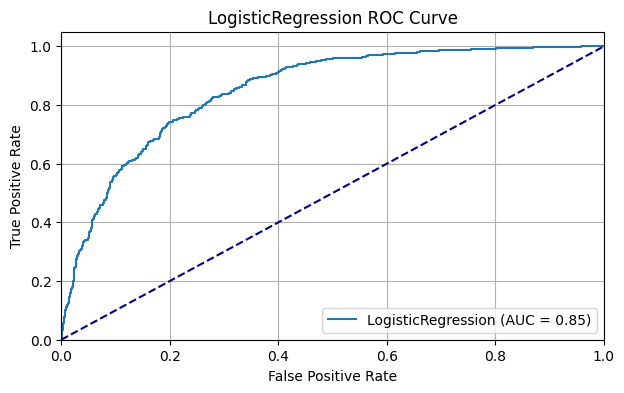

,ROC_AUC,Accuracy,F1 Score
LogisticRegression,0.851872,0.770469,0.642066


In [50]:
# parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'], # Penalty type
    'solver': ['liblinear', 'saga'] # Algorithm to use in the optimization problem
}

# Initialize GridSearchCV with LogisticRegression and the parameter grid
grid_search = GridSearchCV(LogisticRegression(max_iter=10000, random_state=random_state), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(features_upsampled, target_upsampled)

# best hyperparameters and the best model
best_params = grid_search.best_params_
lg_model = grid_search.best_estimator_

# Print the results
print("Best Hyperparameters:", best_params)

get_scores(lg_model, features_test_scaled, target_test, 'LogisticRegression')



LogisticRegression	
Best Hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

ROC_AUC: 0.851872	  Accuracy: 0.770469	 F1 Score: 0.642066


### Random Forest Classifier

Best Hyperparameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}


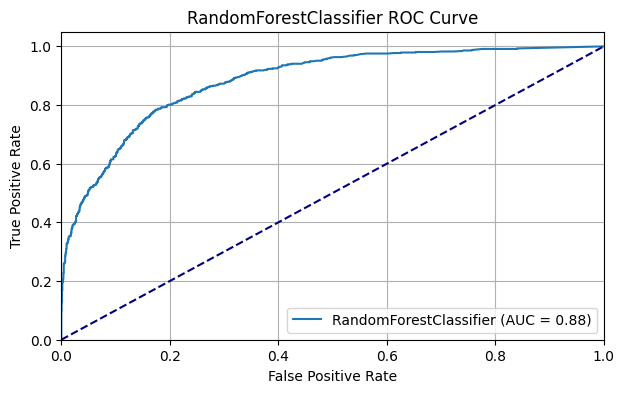

,ROC_AUC,Accuracy,F1 Score
RandomForestClassifier,0.883143,0.826787,0.639053


In [51]:
# Parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize RandomizedSearchCV with RandomForestClassifier and the parameter grid
random_search = RandomizedSearchCV(RandomForestClassifier(class_weight='balanced', random_state=random_state),
                                   param_distributions=param_grid, n_iter=100, scoring='roc_auc', cv=5, n_jobs=-1, random_state=random_state)

# Fit random search model
random_search.fit(features_upsampled, target_upsampled)

# Best hyperparameters and the best model
best_params = random_search.best_params_
rf_model = random_search.best_estimator_

# Print the results
print("Best Hyperparameters:", best_params)

get_scores(rf_model, features_test_scaled, target_test, 'RandomForestClassifier')


Best Hyperparameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}
	ROC_AUC	Accuracy	F1 Score
RandomForestClassifier	0.883143	0.826787	0.639053

### Cat Boost Classifier

Best parameters found:  {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 1000, 'depth': 8}


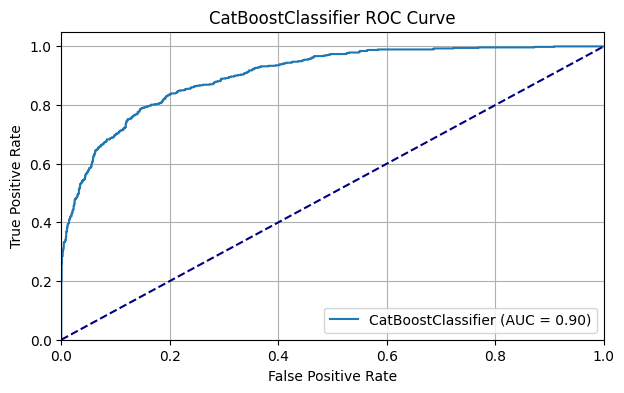

,ROC_AUC,Accuracy,F1 Score
CatBoostClassifier,0.902834,0.836252,0.718241


In [52]:
# longer run time but similar results to the model without testing different parameters

# Initialize the CatBoost classifier with basic parameters
model = CatBoostClassifier(
    class_weights=[11, 13],
    random_seed=42,
    logging_level='Silent'
)

# parameters
param_dist = {
    'iterations': [500, 1000],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [3, 5, 7],
}

# Cross-validation 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=50, cv=cv, scoring='roc_auc', n_jobs=-1, random_state=42)
random_search.fit(features_upsampled, target_upsampled)

# Best model
cbc_model = random_search.best_estimator_
print("Best parameters found: ", random_search.best_params_)

# Train best model
cbc_model.fit(features_upsampled, target_upsampled, eval_set=(features_test_scaled, target_test), early_stopping_rounds=50, verbose=False)

# Evaluate the model
get_scores(cbc_model, features_test_scaled, target_test, 'CatBoostClassifier')


CatBoostClassifier

Best parameters found:  {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 1000, 'depth': 8}

AUC-ROC Score: 0.902834   Test Accuracy: 0.836252    F1 Score : 0.718241

### KNN Classifier

Best Hyperparameters: {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 12, 'p': 1, 'weights': 'distance'}


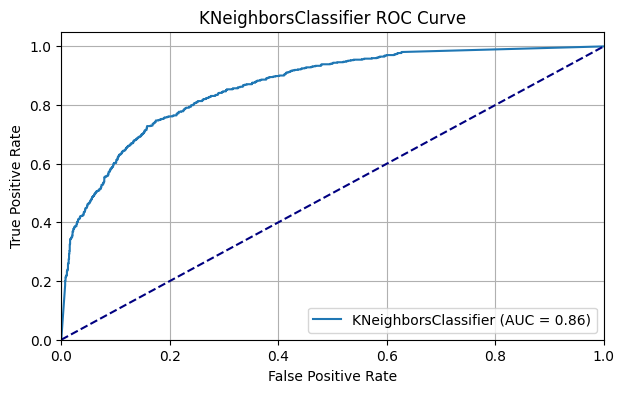

,ROC_AUC,Accuracy,F1 Score
KNeighborsClassifier,0.864828,0.785613,0.659654


In [53]:
# parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 12], # Number of neighbors
    'weights': ['uniform', 'distance'], # Weight function 
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute the nearest neighbors
    'p': [1, 2],   # Power parameter 
    'metric': ['euclidean', 'manhattan'] # Distance metric
}

# Create a KNN classifier
knn_classifier = KNeighborsClassifier(weights='distance')

# grid search with cross-validation
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(features_upsampled, target_upsampled)

# best hyperparameters
best_params = grid_search.best_params_

# KNN classifier with best parameters
best_knn_classifier = KNeighborsClassifier(**best_params)

# Train the model 
best_knn_classifier.fit(features_upsampled, target_upsampled)

# predictions on the testing set
print("Best Hyperparameters:", best_params)
get_scores(best_knn_classifier, features_test_scaled, target_test, 'KNeighborsClassifier')



KNeighborsClassifier

Best Hyperparameters: {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 12, 'p': 1, 'weights': 'distance'}

ROC_AUC: 0.864828	Accuracy: 0.785613	F1 Score: 0.659654

### Voting Classifier

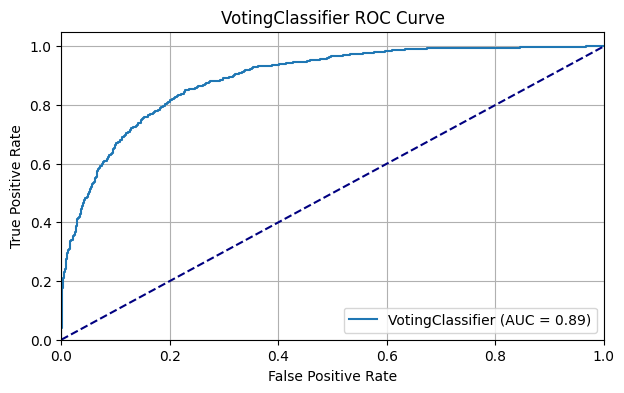

,ROC_AUC,Accuracy,F1 Score
VotingClassifier,0.889691,0.807383,0.692366


In [54]:
# 3 models (all the best models for their respective models on the test set)
m1 = LogisticRegression(max_iter=10000, random_state=random_state)
m2 = RandomForestClassifier(n_estimators=500, max_depth=12,class_weight='balanced', random_state=random_state)
m3= CatBoostClassifier(
    class_weights=[7, 10],
    random_seed=42,
    logging_level='Silent',
    learning_rate= 0.01, 
    l2_leaf_reg= 9, 
    iterations= 500, 
    depth= 6, 
    border_count= 50)


# initialize
voting_classifier = VotingClassifier(
    estimators = [('lr', m1), ('rf', m2), ('gb', m3)],
    voting='soft'
)

# train and evaluate model
voting_classifier.fit(features_upsampled, target_upsampled)
get_scores(voting_classifier, features_test_scaled, target_test, 'VotingClassifier')


## Model Performance overview

In [55]:
score_table = pd.concat(scorers)
score_table

,ROC_AUC,Accuracy,F1 Score
DummyClassifier,0.500000,0.728348,0.000000
LogisticRegression,0.851872,0.770469,0.642066
RandomForestClassifier,0.883143,0.826787,0.639053
CatBoostClassifier,0.902834,0.836252,0.718241
KNeighborsClassifier,0.864828,0.785613,0.659654
VotingClassifier,0.889691,0.807383,0.692366


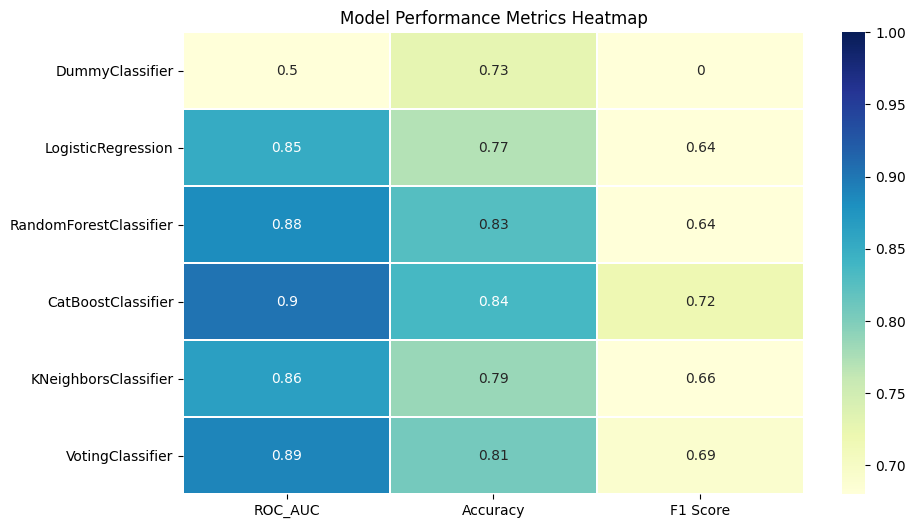

In [56]:
# Plotting
plt.figure(figsize=(10, 6))
sns.heatmap(score_table, annot=True, cmap='YlGnBu', cbar=True, vmin=0.68, vmax=1.0, linewidths=0.5)

# Labels and title
plt.title('Model Performance Metrics Heatmap')

# Show the plot
plt.show()


From the heatmap, we can visually distingush the prefomance of the models on the test set. The CatBoostClassifier preformed the best overall, with the highest scores. 0.9 ROC_AUC score, 0.84 accuracy and 0.72 F1 score. The VotingClassifier which combines the prediction of 3 models (LogisticRegression, RandomForestClassifier and CatBoostClassifier) and the RandomForestClassifier also did well. 

# Solution Report

After the data was cleaned, feature engineering was preformed, categorical values were label encoded. Data was split to train and test sets (4:1), and charges columns were scaled. 

The get_scores function to make model predictions on the test set and get the metric scores (auc-roc, accuracy and F1 score) was created. A scorer array was used to store the scores for every model that the function was used with. 

Machine learning models were tuned with the train data set and the the get_scores function as used to get the  performance of the model. Focusing on getting a high auc-roc score. 

<b> ML models utilized: logistic Regression (LR), Random Forest Classifier (RFC), Cat Boost Classifier (CBC), KNN classifier and a voting Classfier. <b>

The voting classifer was not part of the action plan prior to model training. After seeing the performace of the LR, RFC and the CBC, I was curious on how a model that takes the predictions based on a collection of models might perform. This Voting classifier comprised of the LR, RFC and CBC models. 

The run time for models like RFC and CBC was long due the combination of parameters. After some searching on the internet, I found that parameter tuning with RandomSearchCV would be faster than a GridSearchCV due to the way RandomSearchCV randomly selects parameters to get the highest metric score instead of training on every parameter combination specified in the gird. 

After model training. The scorer array which consisted of the models and their metrics, was turned in to a dataframe. Using this dataframe heatmap was ploted to vizualize the performace of the models. The darker blue was an indicator of a high auc-roc score. 

<b> Overall, the CatBoostClassifier had the highest metric scores on the test set with a ROC_AUC of 0.9. Making it a good option for forecasting customers who may be at risk of leaving the company. <b>


<b> Best performing model scores <b>

In [57]:
score_table.loc[['CatBoostClassifier']]

,ROC_AUC,Accuracy,F1 Score
CatBoostClassifier,0.902834,0.836252,0.718241


In [58]:
print(f'CatBoostClassifier model params: {random_search.best_params_}')

CatBoostClassifier model params: {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 1000, 'depth': 8}
